# <center> Tests de différentes architectures MobileNet

On compare ici différentes architectures avec exactement les mêmes hyperparamètres que pour ResNet18 c'est à dire :
- Même split train / val / test
- Même preprocessing
- Même nombre d’epochs
- Même optimizer (Adam)
- Même early stopping

Stratégie en 2 phases :

Phase 1 — Head-only training (comme ResNet18, on freeze tous les paramètres du modèle et on entraine uniquement la couche finale)
→ Permet comparaison équitable

Phase 2 — Fine-tuning partiel (optionnel mais intéressant, on débloque les 1-2 dernières couches mais risque de surapprentissage)
→ Permet voir si les performances stagnent à cause du gel

Pour chaque modèle :
| Modèle | Accuracy | F1 weighted | Params | Temps d’entraînement |
| ------ | -------- | ----------- | ------ | -------------------- |


Nous nous consacrons dans ce notebook à tester différents arcitecture MobileNet :  
- MobileNet V2
- MobileNet V3-Small



### 0. Préparation des hyper-paramètres et du dataset

#### Imports de base

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
from pathlib import Path

# Pour que notre archi fonctionne avec google colab

!git clone https://github.com/julietteabalain-cloud/Reconnaissance-de-mouvement-artistique.git
!cd /content/Reconnaissance-de-mouvement-artistique && git pull
%cd /content/Reconnaissance-de-mouvement-artistique


Cloning into 'Reconnaissance-de-mouvement-artistique'...
remote: Enumerating objects: 451, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 451 (delta 118), reused 108 (delta 52), pack-reused 272 (from 2)
Receiving objects: 100% (451/451), 100.28 MiB | 22.19 MiB/s, done.
Resolving deltas: 100% (271/271), done.
Already up to date.
/content/Reconnaissance-de-mouvement-artistique


In [3]:
from pathlib import Path
REPO_NAME = "Reconnaissance-de-mouvement-artistique"
PROJECT_ROOT = Path(f"/content/{REPO_NAME}")
sys.path.append(str(PROJECT_ROOT))

In [4]:
from src.dataset_dl import ArtDataset
from src.train import train_model, train_one_epoch, validate_one_epoch

from src.dataset import load_df_train_test_val, load_df
from src.preprocessing import clean_dataset

from src.models import get_model
from src.evaluate import *
from src.utils import set_seed

#Fixer l'initialisation aléatoire pour la reproductibilité
set_seed(42)

#pour avoir acces au GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
DATA_ROOT = Path("/content/drive/MyDrive/DeepLearning/WikiArt_Subset")

df_test, df_train, df_val = load_df_train_test_val(DATA_ROOT)
df = load_df(DATA_ROOT)

df, df_train, df_val, df_test = clean_dataset(df, df_train, df_val, df_test)

/content/Reconnaissance-de-mouvement-artistique/src/preprocessing.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["style_encoded"] = dataset["style_name"].map(style_to_idx)
/content/Reconnaissance-de-mouvement-artistique/src/preprocessing.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["style_encoded"] = dataset["style_name"].map(style_to_idx)
/content/Reconnaissance-de-mouvement-artistique/src/preprocessing.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

#### Dataset de deep learning

In [15]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    # ajout de data augmentation pour le training set
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [16]:
IMAGE_ROOT_TRAIN = DATA_ROOT / "train"
IMAGE_ROOT_VAL = DATA_ROOT / "val"
IMAGE_ROOT_TEST = DATA_ROOT / "test"

train_dataset = ArtDataset(
    df_train,
    IMAGE_ROOT_TRAIN,
    transform=transform_train
)

val_dataset = ArtDataset(
    df_val,
    IMAGE_ROOT_VAL,
    transform=transform_val
)

test_dataset = ArtDataset(
    df_test,
    IMAGE_ROOT_TEST,
    transform=transform_val
)

In [17]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,     # ajuster selon ton CPU
    pin_memory=True
)

In [18]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = float("inf")
        self.counter = 0
        self.stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True

### 1. MobileNet v2

→ Architecture légère
→ Depthwise separable convolutions
→ Très peu de paramètres

Le problème nécessite-t-il une grande capacité ou un modèle léger suffit-il ?

#### 2.1 Charger le modèle

In [19]:
num_classes = df_train["style_encoded"].nunique()

model_mn = get_model("mobilenet_v2", num_classes=num_classes)
model_mn = model_mn.to(device)

# ajout de label smoothing pour la cross entropy loss
# label smoothing permet de rendre le modèle moins confiant dans ses prédictions,
# ce qui peut aider à améliorer la généralisation et réduire le surapprentissage
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(
    model_mn.classifier.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 88.8MB/s]


#### 2.2 Entrainement

In [20]:
# from src.utils import EarlyStopping

early_stopping = EarlyStopping(patience=3)

NUM_EPOCHS_FREEZE = 10
history_mn = train_model(
    model_mn,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=NUM_EPOCHS_FREEZE,
    early_stopping=early_stopping
)



Epoch 1/10


Train Loss: 2.5375 | Train Acc: 0.2856 | Val Loss: 2.2012 | Val Acc: 0.4035

Epoch 2/10


Train Loss: 2.1609 | Train Acc: 0.4086 | Val Loss: 2.1348 | Val Acc: 0.4304

Epoch 3/10


Train Loss: 2.0640 | Train Acc: 0.4463 | Val Loss: 2.1174 | Val Acc: 0.4494

Epoch 4/10


Train Loss: 2.0129 | Train Acc: 0.4720 | Val Loss: 2.0626 | Val Acc: 0.4530

Epoch 5/10


Train Loss: 1.9701 | Train Acc: 0.4928 | Val Loss: 2.0748 | Val Acc: 0.4603

Epoch 6/10


Train Loss: 1.9429 | Train Acc: 0.4931 | Val Loss: 2.0502 | Val Acc: 0.4676

Epoch 7/10


Train Loss: 1.9237 | Train Acc: 0.5035 | Val Loss: 2.0689 | Val Acc: 0.4596

Epoch 8/10


Train Loss: 1.9054 | Train Acc: 0.5167 | Val Loss: 2.0910 | Val Acc: 0.4538

Epoch 9/10


Train Loss: 1.8965 | Train Acc: 0.5156 | Val Loss: 2.0925 | Val Acc: 0.4508
Early stopping triggered.


#### 2.3 Evaluation

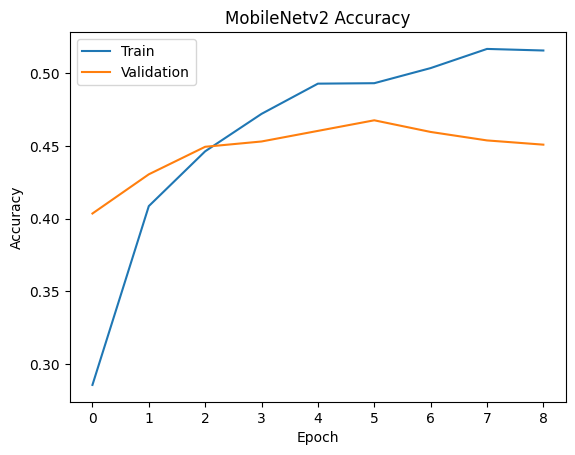

In [21]:
train_acc = history_mn["train_acc"]
val_acc   = history_mn["val_acc"]

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["Train", "Validation"])
plt.title("MobileNetv2 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

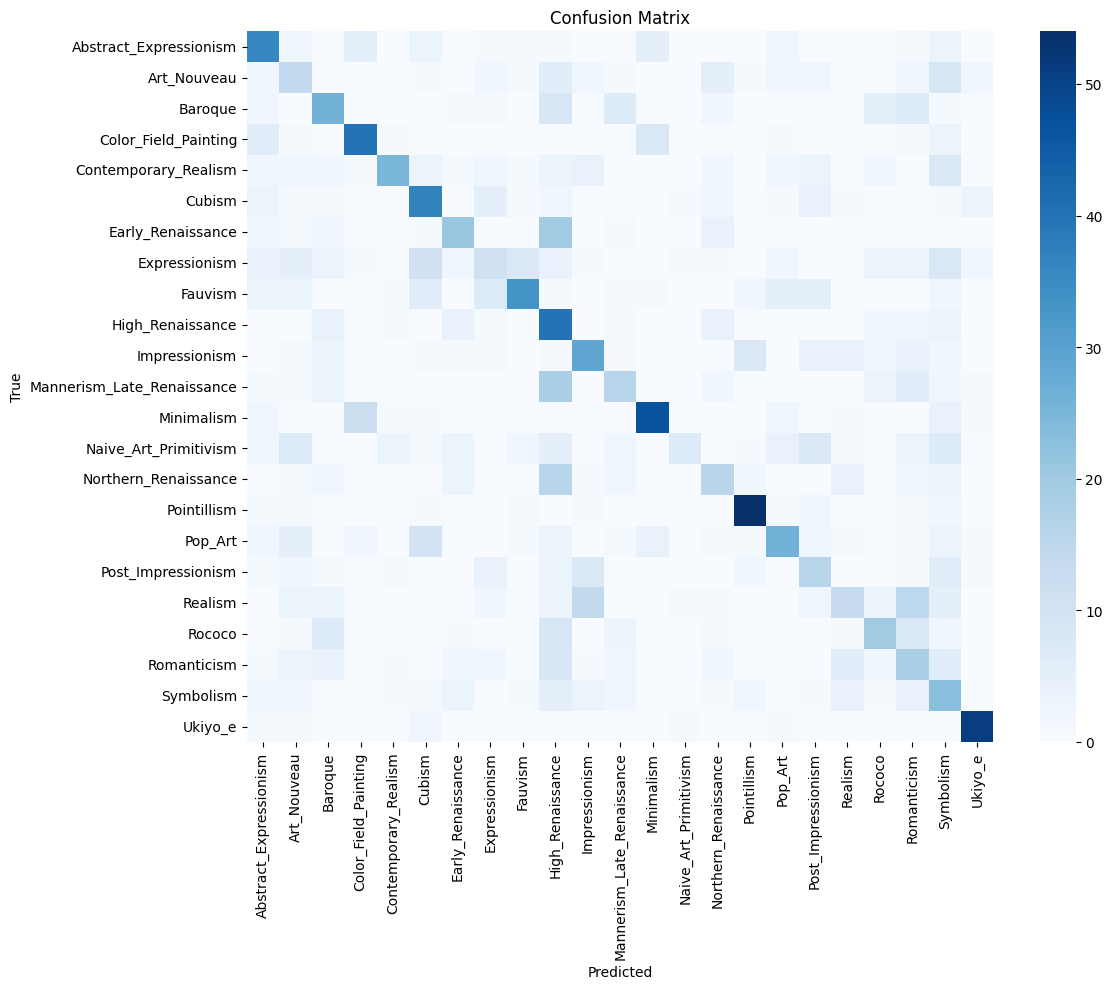

In [24]:
#Confusion matrix :

class_names = sorted(df_train["style_name"].unique())

cm = compute_confusion_matrix(
    model_mn,
    val_loader,
    device,
    class_names
)

plot_confusion_matrix(cm, class_names)


In [25]:
class_names = sorted(df_train["style_name"].unique())

acc_per_style = accuracy_per_class(
    model_mn,
    val_loader,
    device,
    class_names
)

results = list(zip(class_names, acc_per_style))
results = sorted(results, key=lambda x: x[1], reverse=True)

for style, acc in results:
    print(f"{style}: {acc:.3f}")


Ukiyo_e: 0.895
Pointillism: 0.831
Minimalism: 0.662
Color_Field_Painting: 0.656
High_Renaissance: 0.645
Abstract_Expressionism: 0.600
Cubism: 0.587
Fauvism: 0.471
Impressionism: 0.468
Baroque: 0.426
Symbolism: 0.411
Pop_Art: 0.406
Early_Renaissance: 0.404
Contemporary_Realism: 0.397
Rococo: 0.377
Post_Impressionism: 0.348
Northern_Renaissance: 0.308
Romanticism: 0.305
Mannerism_Late_Renaissance: 0.302
Art_Nouveau: 0.269
Realism: 0.200
Expressionism: 0.157
Naive_Art_Primitivism: 0.125


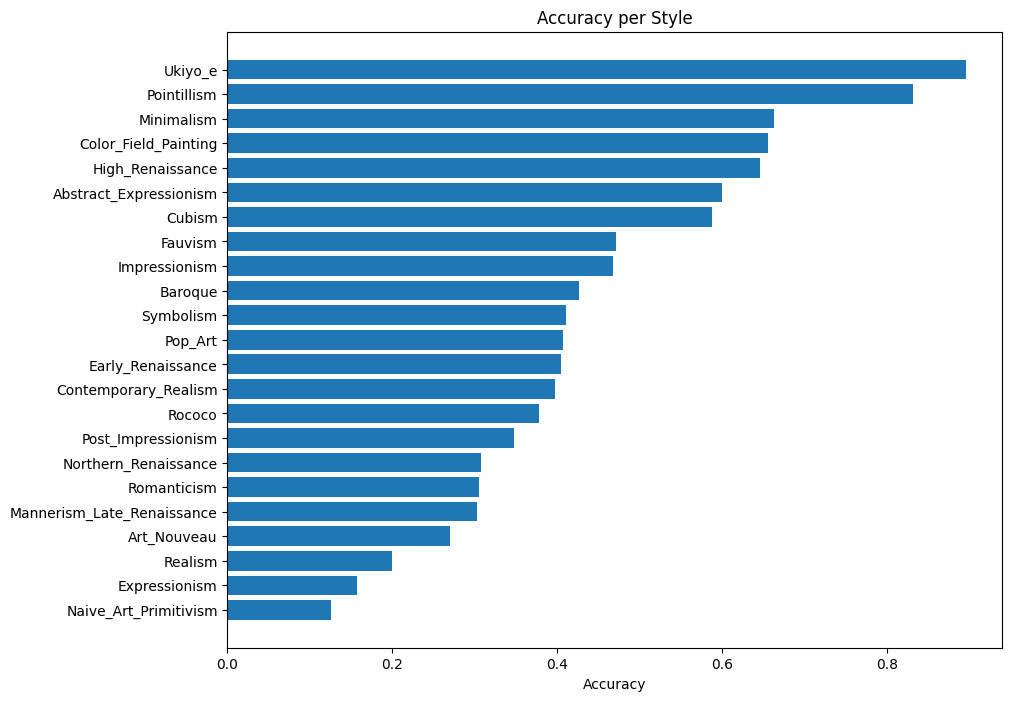

In [26]:
visualize_accuracy_per_style(results)

#### 1.6.2 Evaluation sur l'ensemble de test

In [27]:
best_model_weights = model_mn.state_dict()

test_acc, test_cm, report = evaluate_model(model_mn, test_loader, device)

print(f"Test Accuracy: {test_acc:.3f}")
print("Classification Report:")
print(report)

Test Accuracy: 0.414
Classification Report:
                            precision    recall  f1-score   support

    Abstract_Expressionism     0.3478    0.4898    0.4068        49
               Art_Nouveau     0.2909    0.2909    0.2909        55
                   Baroque     0.3043    0.2333    0.2642        60
      Color_Field_Painting     0.7561    0.6078    0.6739        51
      Contemporary_Realism     0.7273    0.2807    0.4051        57
                    Cubism     0.5000    0.6333    0.5588        60
         Early_Renaissance     0.5745    0.3857    0.4615        70
             Expressionism     0.2903    0.1552    0.2022        58
                   Fauvism     0.5349    0.4182    0.4694        55
          High_Renaissance     0.1957    0.6207    0.2975        58
             Impressionism     0.3766    0.4203    0.3973        69
Mannerism_Late_Renaissance     0.4783    0.3284    0.3894        67
                Minimalism     0.7018    0.7273    0.7143        55
   

Test Confusion Matrix:


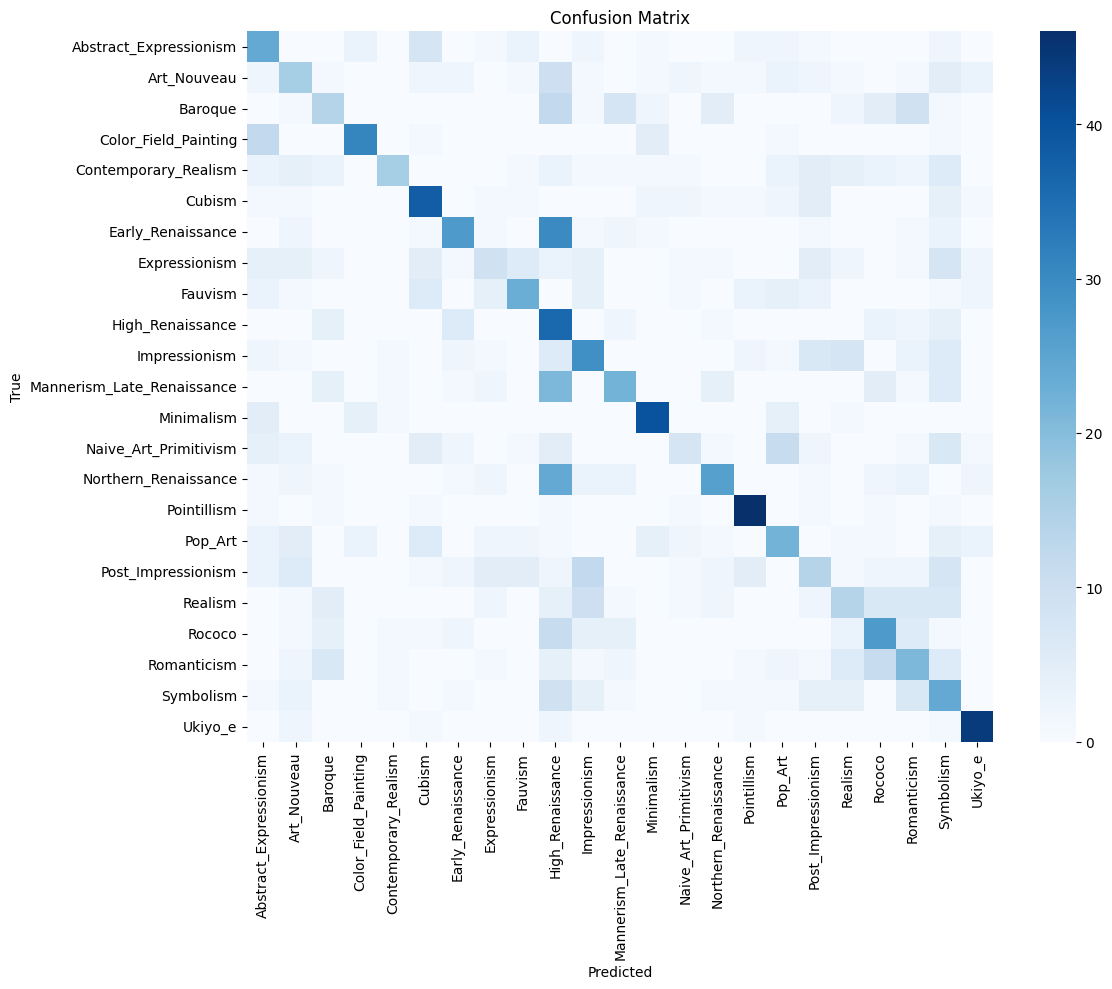

In [28]:
print("Test Confusion Matrix:")
plot_confusion_matrix(test_cm, class_names)

### 2. MobileNet V3 Small 

#### 2.1 Charger le modèle

In [ ]:
num_classes = df_train["style_encoded"].nunique()

model_mn = get_model("mobilenet_v3_small", num_classes=num_classes)
model_mn = model_mn.to(device)

# ajout de label smoothing pour la cross entropy loss
# label smoothing permet de rendre le modèle moins confiant dans ses prédictions,
# ce qui peut aider à améliorer la généralisation et réduire le surapprentissage
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(
    model_mn.classifier.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 93.9MB/s]


#### 2.2 Entrainement

In [ ]:
# from src.utils import EarlyStopping

early_stopping = EarlyStopping(patience=3)

NUM_EPOCHS_FREEZE = 10
history_mn = train_model(
    model_mn,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=NUM_EPOCHS_FREEZE,
    early_stopping=early_stopping
)



Epoch 1/10


Train Loss: 2.6666 | Train Acc: 0.2391 | Val Loss: 2.3459 | Val Acc: 0.3540

Epoch 2/10


Train Loss: 2.3197 | Train Acc: 0.3570 | Val Loss: 2.2502 | Val Acc: 0.3744

Epoch 3/10


Train Loss: 2.2338 | Train Acc: 0.3887 | Val Loss: 2.2010 | Val Acc: 0.3933

Epoch 4/10


Train Loss: 2.1737 | Train Acc: 0.4018 | Val Loss: 2.1755 | Val Acc: 0.4101

Epoch 5/10


Train Loss: 2.1316 | Train Acc: 0.4247 | Val Loss: 2.1445 | Val Acc: 0.4159

Epoch 6/10


Train Loss: 2.1169 | Train Acc: 0.4320 | Val Loss: 2.1443 | Val Acc: 0.4261

Epoch 7/10


Train Loss: 2.0827 | Train Acc: 0.4441 | Val Loss: 2.1406 | Val Acc: 0.4181

Epoch 8/10


Train Loss: 2.0758 | Train Acc: 0.4419 | Val Loss: 2.1411 | Val Acc: 0.4283

Epoch 9/10


Train Loss: 2.0553 | Train Acc: 0.4546 | Val Loss: 2.1248 | Val Acc: 0.4261

Epoch 10/10


Train Loss: 2.0414 | Train Acc: 0.4604 | Val Loss: 2.1186 | Val Acc: 0.4334


#### 2.3 Evaluation

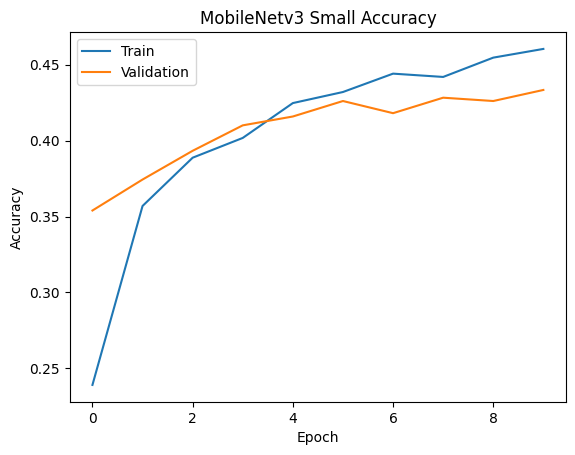

In [ ]:
train_acc = history_mn["train_acc"]
val_acc   = history_mn["val_acc"]

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["Train", "Validation"])
plt.title("MobileNetv3 Small Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

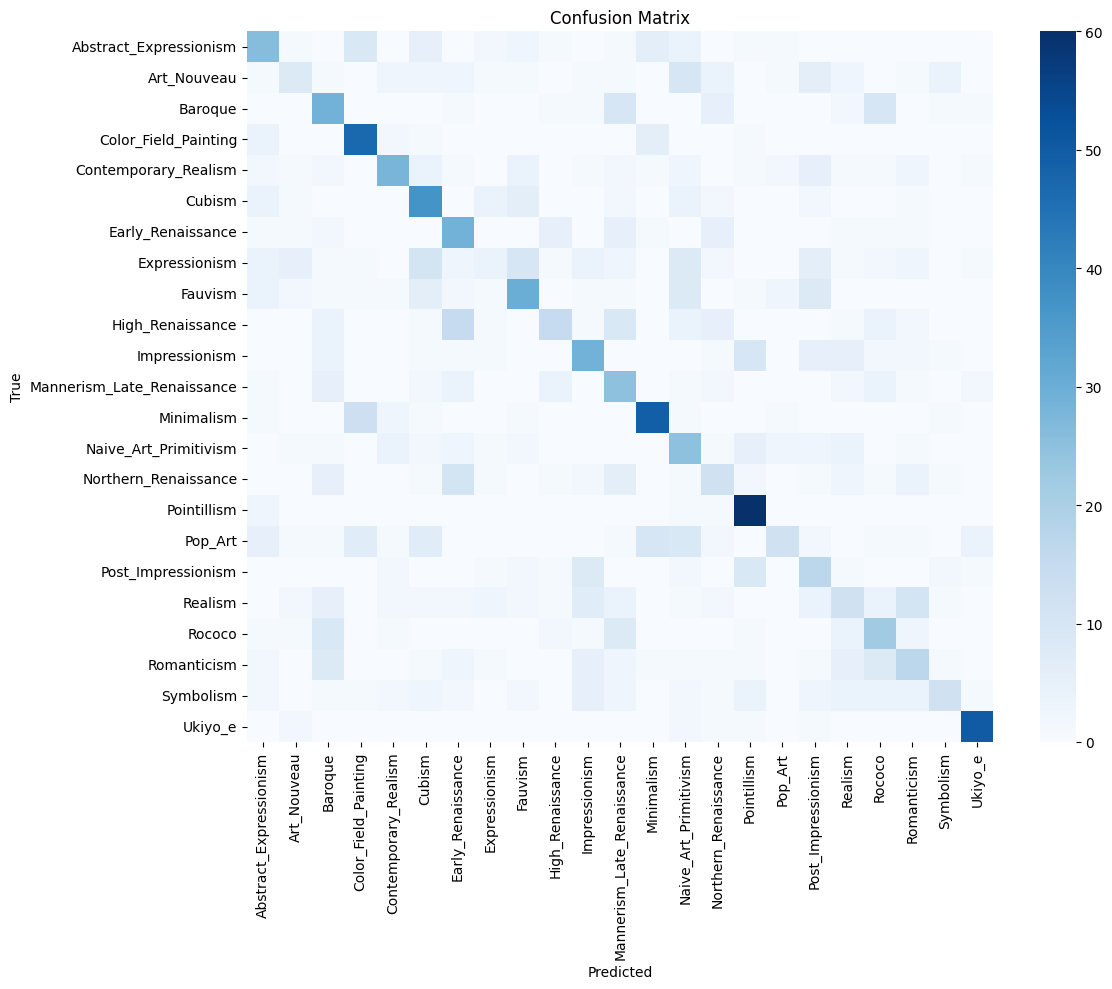

In [ ]:
#Confusion matrix :

class_names = sorted(df_train["style_name"].unique())

cm = compute_confusion_matrix(
    model_mn,
    val_loader,
    device,
    class_names
)

plot_confusion_matrix(cm, class_names)


In [ ]:
class_names = sorted(df_train["style_name"].unique())

acc_per_style = accuracy_per_class(
    model_mn,
    val_loader,
    device,
    class_names
)

results = list(zip(class_names, acc_per_style))
results = sorted(results, key=lambda x: x[1], reverse=True)

for style, acc in results:
    print(f"{style}: {acc:.3f}")


Pointillism: 0.923
Ukiyo_e: 0.877
Color_Field_Painting: 0.770
Minimalism: 0.690
Cubism: 0.587
Early_Renaissance: 0.558
Baroque: 0.475
Mannerism_Late_Renaissance: 0.472
Impressionism: 0.468
Naive_Art_Primitivism: 0.446
Contemporary_Realism: 0.444
Abstract_Expressionism: 0.433
Fauvism: 0.429
Rococo: 0.415
Post_Impressionism: 0.370
Romanticism: 0.288
High_Renaissance: 0.242
Northern_Renaissance: 0.231
Symbolism: 0.214
Pop_Art: 0.188
Realism: 0.185
Art_Nouveau: 0.154
Expressionism: 0.057


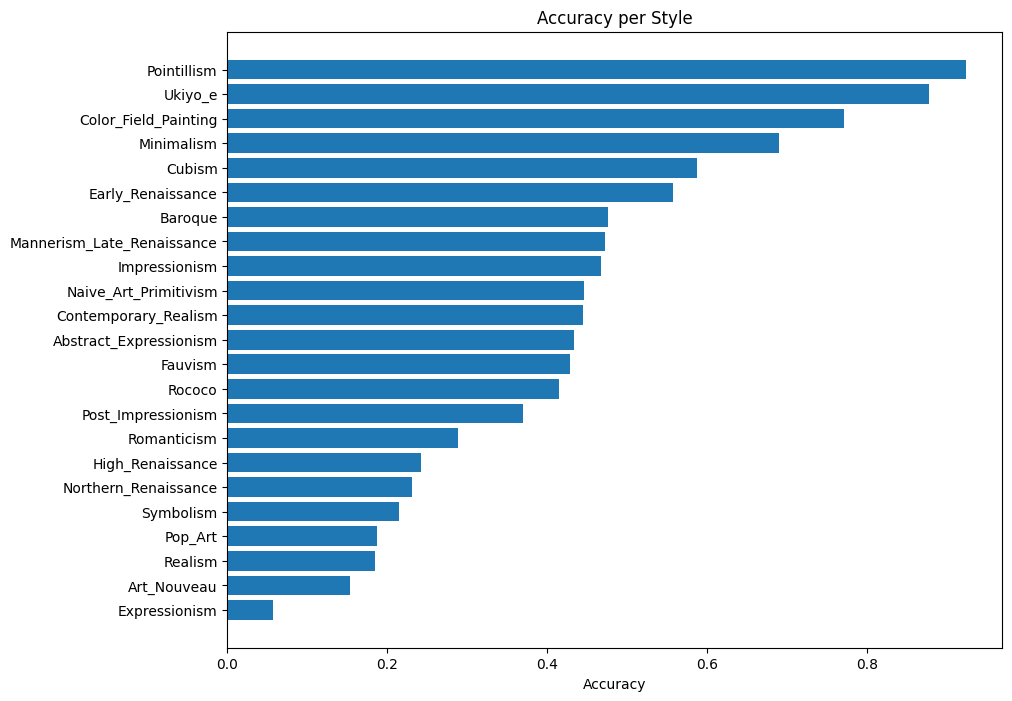

In [ ]:
visualize_accuracy_per_style(results)

#### 1.6.2 Evaluation sur l'ensemble de test

In [ ]:
best_model_weights = model_mn.state_dict()

test_acc, test_cm, report = evaluate_model(model_mn, test_loader, device)

print(f"Test Accuracy: {test_acc:.3f}")
print("Classification Report:")
print(report)

Test Accuracy: 0.404
Classification Report:
                            precision    recall  f1-score   support

    Abstract_Expressionism     0.3265    0.3265    0.3265        49
               Art_Nouveau     0.3684    0.1273    0.1892        55
                   Baroque     0.3053    0.4833    0.3742        60
      Color_Field_Painting     0.5763    0.6667    0.6182        51
      Contemporary_Realism     0.5588    0.3333    0.4176        57
                    Cubism     0.4487    0.5833    0.5072        60
         Early_Renaissance     0.4405    0.5286    0.4805        70
             Expressionism     0.1875    0.0517    0.0811        58
                   Fauvism     0.4407    0.4727    0.4561        55
          High_Renaissance     0.3030    0.1724    0.2198        58
             Impressionism     0.2895    0.3188    0.3034        69
Mannerism_Late_Renaissance     0.4565    0.6269    0.5283        67
                Minimalism     0.6667    0.7273    0.6957        55
   

Test Confusion Matrix:


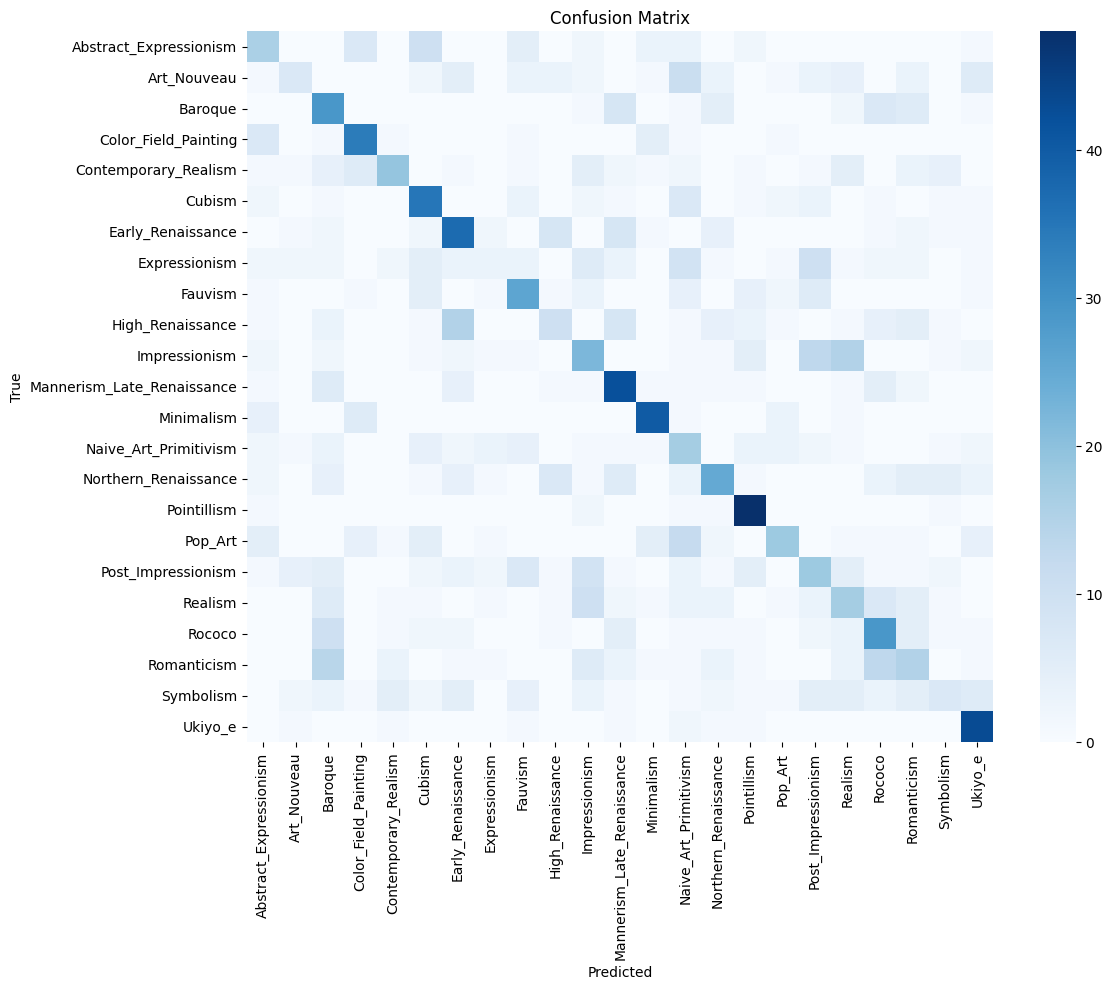

In [ ]:
print("Test Confusion Matrix:")
plot_confusion_matrix(test_cm, class_names)